## EAST (An Efficient and Accurate Scene Text Detector)

Text detection approach. The pipeline directly predicts words or text lines of arbitrary orientations and quadrilateral shapes in full images, eliminating unnecessary intermediate steps (e.g., candidate aggregation and word partitioning), with a single neural network. The simplicity of the pipeline allows concentrating efforts on designing loss functions and neural network architecture.
- Paper: https://arxiv.org/abs/1704.03155v2
- Github: https://github.com/argman/EAST 

[NOTE] jika ada error, berarti model belum di download. download model `model.ckpt-49491.data-00000-of-00001` dari https://drive.google.com/file/d/0B3APw5BZJ67ETHNPaU9xUkVoV0U/view dan letakkan pada folder `east_icdar2015_resnet_v1_50_rbox`

In [1]:
import os
import operator

import time
import datetime
import cv2
import numpy as np
import uuid
import json

import functools
import logging
import collections

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

logger.info('loading model')
import tensorflow as tf
from east import model
from east.icdar import restore_rectangle
from east import lanms
from east.eval import resize_image, sort_poly, detect

checkpoint_path = "east_icdar2015_resnet_v1_50_rbox/"

input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')
global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)

f_score, f_geometry = model.model(input_images, is_training=False)

variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
saver = tf.train.Saver(variable_averages.variables_to_restore())

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.65
sess = tf.Session(config=config)

ckpt_state = tf.train.get_checkpoint_state(checkpoint_path)
model_path = os.path.join(checkpoint_path, os.path.basename(ckpt_state.model_checkpoint_path))
logger.info('Restore from {}'.format(model_path))
saver.restore(sess, model_path)


@functools.lru_cache(maxsize=1)
def get_host_info():
    ret = {}
    with open('/proc/cpuinfo') as f:
        ret['cpuinfo'] = f.read()

    with open('/proc/meminfo') as f:
        ret['meminfo'] = f.read()

    with open('/proc/loadavg') as f:
        ret['loadavg'] = f.read()

    return ret


def draw_illu(illu, rst):
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        cv2.polylines(illu, [d], isClosed=True, color=(255, 255, 0))
    return illu

def predictor(img):
    start_time = time.time()
    rtparams = collections.OrderedDict()
    rtparams['start_time'] = datetime.datetime.now().isoformat()
    rtparams['image_size'] = '{}x{}'.format(img.shape[1], img.shape[0])
    timer = collections.OrderedDict([
        ('net', 0),
        ('restore', 0),
        ('nms', 0)
    ])

    im_resized, (ratio_h, ratio_w) = resize_image(img)
    rtparams['working_size'] = '{}x{}'.format(
        im_resized.shape[1], im_resized.shape[0])
    start = time.time()
    score, geometry = sess.run(
        [f_score, f_geometry],
        feed_dict={input_images: [im_resized[:,:,::-1]]})
    timer['net'] = time.time() - start

    boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
    logger.info('net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
        timer['net']*1000, timer['restore']*1000, timer['nms']*1000))

    if boxes is not None:
        scores = boxes[:,8].reshape(-1)
        boxes = boxes[:, :8].reshape((-1, 4, 2))
        boxes[:, :, 0] /= ratio_w
        boxes[:, :, 1] /= ratio_h

    duration = time.time() - start_time
    timer['overall'] = duration
    logger.info('[timing] {}'.format(duration))

    text_lines = []
    if boxes is not None:
        text_lines = []
        for box, score in zip(boxes, scores):
            box = sort_poly(box.astype(np.int32))
            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                continue
            tl = collections.OrderedDict(zip(
                ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'],
                map(float, box.flatten())))
            tl['score'] = float(score)
            text_lines.append(tl)
    ret = {
        'text_lines': text_lines,
        'rtparams': rtparams,
        'timing': timer,
    }
    ret.update(get_host_info())
    return ret

resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
INFO:tensorflow:Restoring parameters from east_icdar2015_resnet_v1_50_rbox/model.ckpt-49491


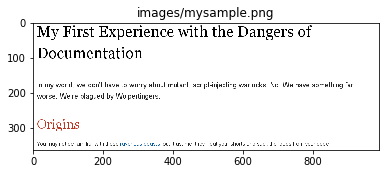

In [2]:
import matplotlib.pyplot as plt

im_name = "images/mysample.png"

img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(im_name)
plt.imshow(img)
rst = predictor(img)


def get_boxes_east(rst) :
    bbox = []
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        min_x = min(d[0][0], d[3][0])
        min_y = min(d[0][1], d[1][1])
        max_x = max(d[1][0], d[2][0])
        max_y = max(d[2][1], d[3][1])
        if min_x >= 0 and min_y >= 0 and max_x >= 0 and max_y >= 0 :
            bbox.append([min_x, min_y, max_x, max_y])
        
    return bbox

bbox = get_boxes_east(rst)

/home/mhilmiasyrofi/tensorflow-py3/venv/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


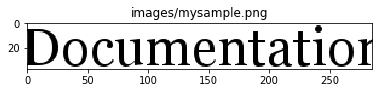

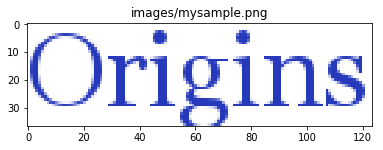

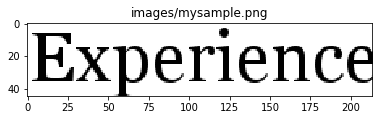

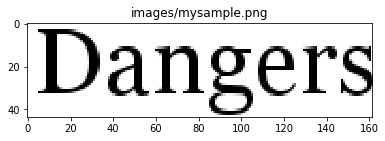

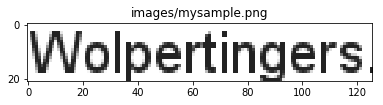

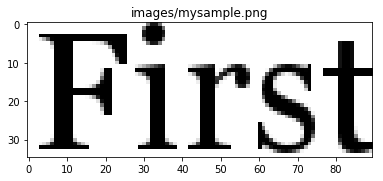

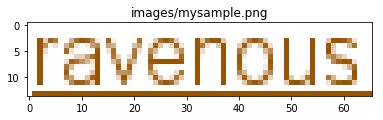

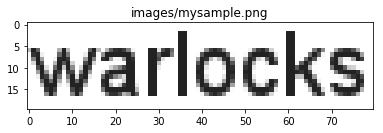

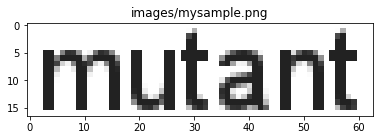

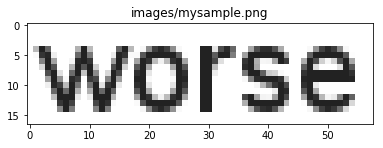

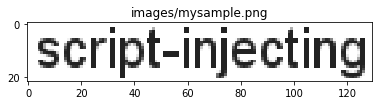

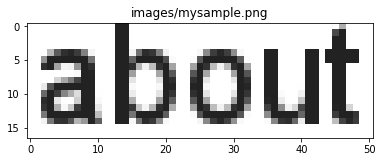

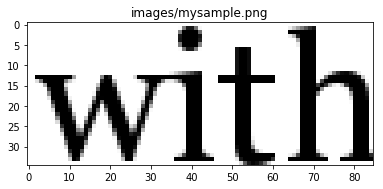

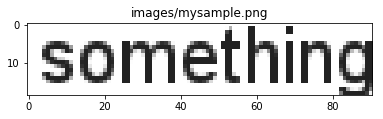

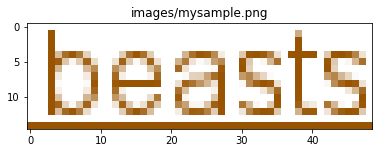

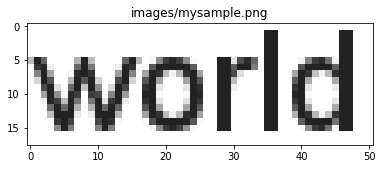

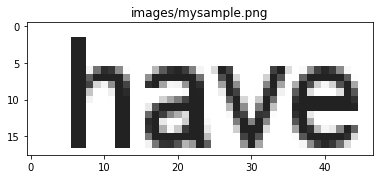

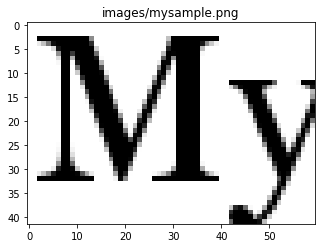

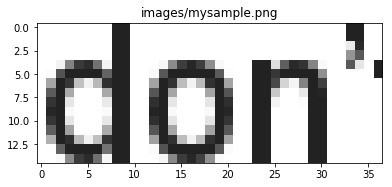

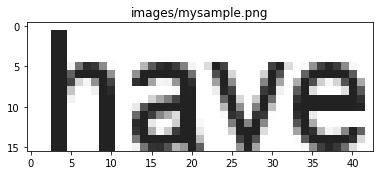

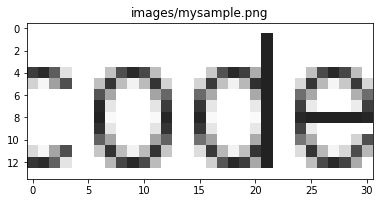

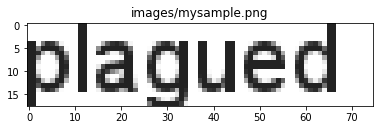

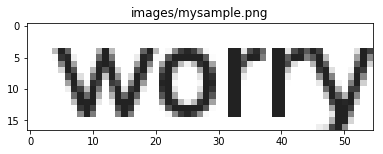

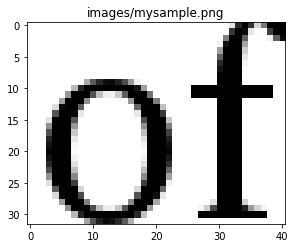

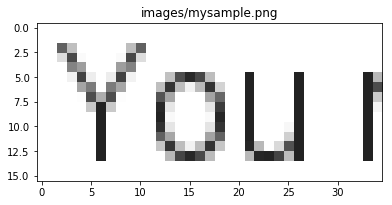

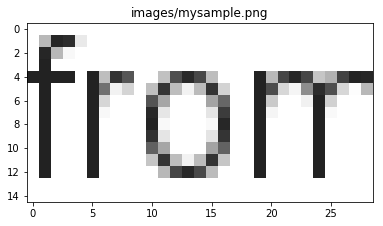

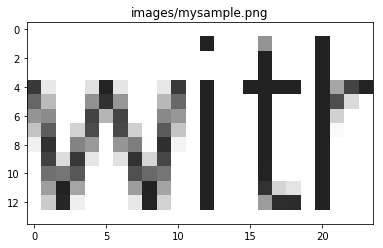

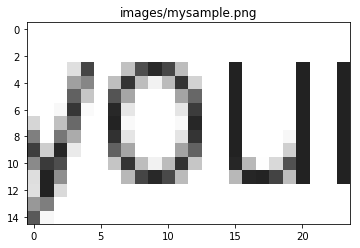

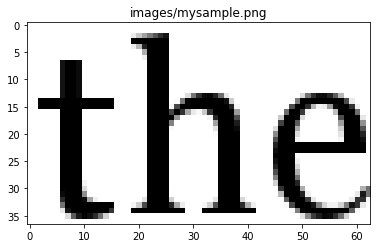

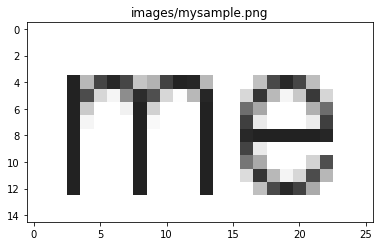

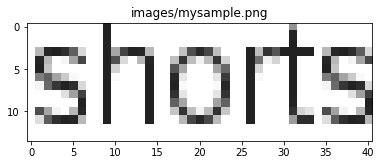

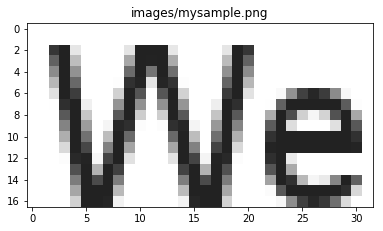

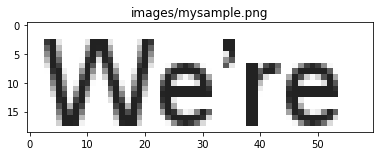

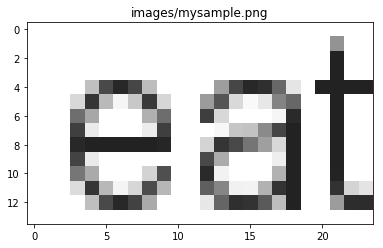

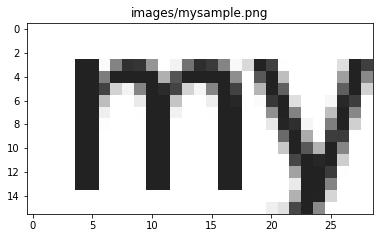

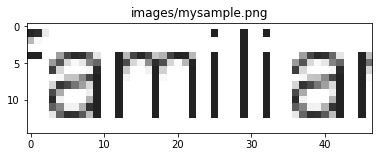

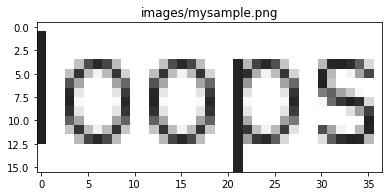

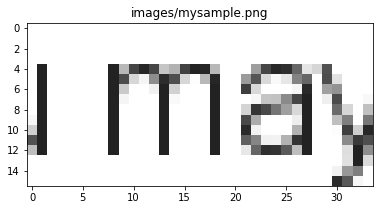

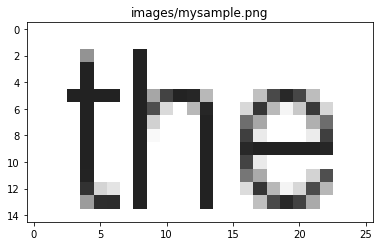

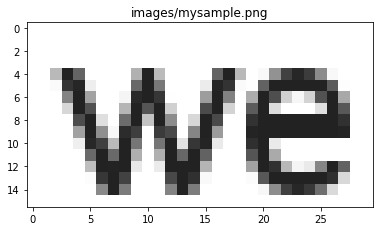

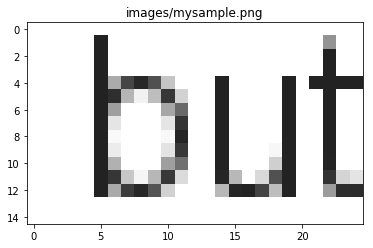

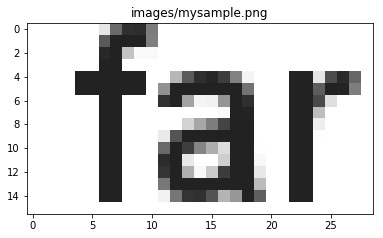

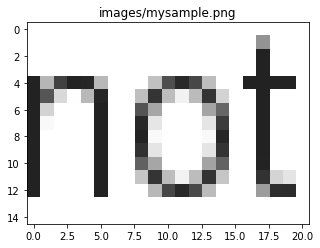

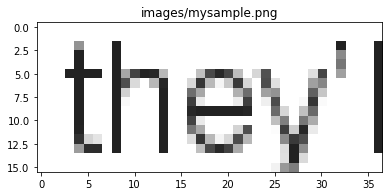

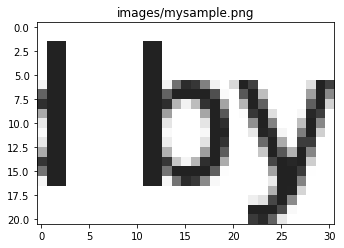

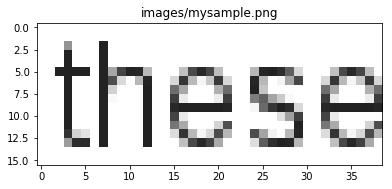

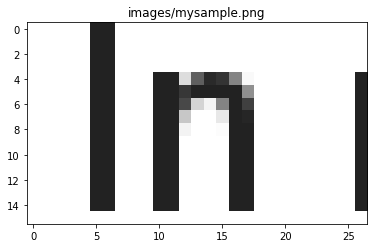

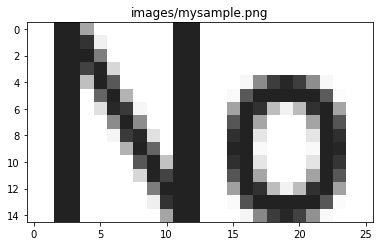

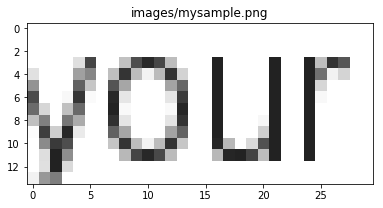

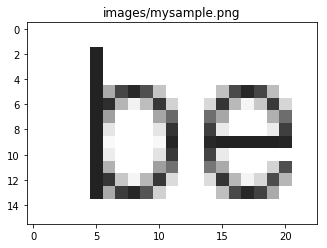

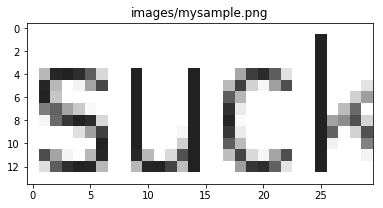

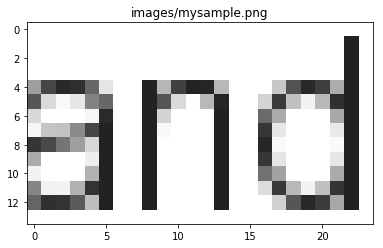

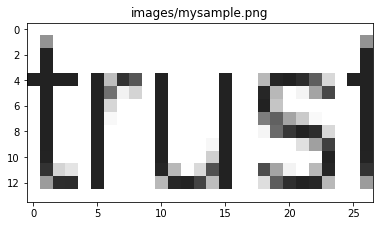

In [3]:
imgs = []
img = cv2.imread(im_name)
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
    imgs.append(crop_img)
    
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(im_name)
    plt.imshow(crop_img)

## Bounding Box analsys untuk mendapatkan sekumpulan kata

In [6]:
# print(bbox)

class BoundingBox:
    x1 = 0
    x2 = 0
    y1 = 0
    y2 = 0
    width = 0
    height = 0
    
    def __init__(self, x1, x2, y1, y2):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.width = self.y2 - self.y1
        self.height = self.x2 - self.x1
        
    def __str__(self):
        return "" + str(self.x1) + ", " + str(self.x2) + ", " + str(self.y1) + ", " + str(self.y2) + ", " + str(self.width) + ", " + str(self.height) + "\n"

In [7]:
data = []
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    box = BoundingBox(x1, x2, y1, y2)
    data.append(box)
    
data.sort(key = operator.attrgetter("x1")) 

# for d in data:
#     print(d)

6, 51, 186, 400, 214, 45

7, 44, 509, 572, 63, 37

8, 43, 412, 497, 85, 35

9, 53, 581, 743, 162, 44

9, 44, 84, 174, 90, 35

9, 51, 10, 70, 60, 42

11, 43, 755, 796, 41, 32

68, 106, 16, 302, 286, 38

169, 189, 587, 667, 80, 20

169, 191, 454, 584, 130, 22

169, 187, 200, 247, 47, 18

169, 186, 712, 744, 32, 17

170, 187, 384, 447, 63, 17

170, 189, 794, 885, 91, 19

170, 188, 64, 115, 51, 18

170, 186, 748, 791, 43, 16

171, 188, 330, 381, 51, 17

171, 186, 157, 194, 37, 15

171, 188, 270, 325, 55, 17

171, 187, 122, 152, 30, 16

171, 187, 888, 917, 29, 16

171, 187, 8, 35, 27, 16

171, 186, 677, 703, 26, 15

172, 188, 30, 59, 29, 16

200, 221, 236, 362, 126, 21

200, 219, 74, 134, 60, 19

201, 222, 200, 231, 31, 21

203, 220, 9, 67, 58, 17

203, 221, 136, 211, 75, 18

273, 310, 11, 135, 124, 37

338, 354, 9, 44, 35, 16

338, 353, 673, 699, 26, 15

338, 354, 460, 497, 37, 16

338, 354, 205, 244, 39, 16

338, 354, 95, 118, 23, 16

339, 354, 314, 363, 49, 15

339, 353, 814, 845, 31, 14

In [11]:
sentences = [[]]
sentence = []
threshold = 0
if len(data) > 0 :
    sentence.append(data[0])
    upper_threshold = data[0].x1
    lower_threshold = data[0].x2
    interval_threshold = data[0].height/2
    for i in range(1, len(data)):
        if abs(data[i].x1 - upper_threshold) < interval_threshold or abs(data[i].x2 - lower_threshold) < interval_threshold :
            sentence.append(data[i])
        else:
            sentences.append(sentence)
            sentence = []
            upper_threshold = data[i].x1
            lower_threshold = data[i].x2
            interval_threshold = data[i].height/2
            sentence.append(data[i])

In [12]:
for s in sentences:
    for k in s:
        print(k)
    print()
    print()



6, 51, 186, 400, 214, 45

7, 44, 509, 572, 63, 37

8, 43, 412, 497, 85, 35

9, 53, 581, 743, 162, 44

9, 44, 84, 174, 90, 35

9, 51, 10, 70, 60, 42

11, 43, 755, 796, 41, 32



68, 106, 16, 302, 286, 38



169, 189, 587, 667, 80, 20

169, 191, 454, 584, 130, 22

169, 187, 200, 247, 47, 18

169, 186, 712, 744, 32, 17

170, 187, 384, 447, 63, 17

170, 189, 794, 885, 91, 19

170, 188, 64, 115, 51, 18

170, 186, 748, 791, 43, 16

171, 188, 330, 381, 51, 17

171, 186, 157, 194, 37, 15

171, 188, 270, 325, 55, 17

171, 187, 122, 152, 30, 16

171, 187, 888, 917, 29, 16

171, 187, 8, 35, 27, 16

171, 186, 677, 703, 26, 15

172, 188, 30, 59, 29, 16



200, 221, 236, 362, 126, 21

200, 219, 74, 134, 60, 19

201, 222, 200, 231, 31, 21

203, 220, 9, 67, 58, 17

203, 221, 136, 211, 75, 18



273, 310, 11, 135, 124, 37



